# 🏁 Fase 8: Torneo de Modelos y Selección del Campeón (Random Forest)

### 🧠 Contexto: El Juicio Final
Después de 7 fases de optimización exhaustiva, hemos llegado al punto de decisión. No basta con que un modelo sea bueno en el entrenamiento; su verdadero valor reside en su capacidad para salvar vidas en el mundo real. En este notebook, enfrentamos a las **5 configuraciones maestras** obtenidas en las fases previas bajo un entorno de validación riguroso.

### 🎯 Objetivos de esta Fase:
1. **Benchmarking Final:** Comparar cara a cara el rendimiento de las diferentes estrategias de balanceo (Class Weight, SMOTE, ADASYN, etc.) utilizando sus hiperparámetros óptimos ya descubiertos.
2. **Evaluación de la Matriz de Confusión:** Analizar no solo el F1-Score, sino el equilibrio entre Falsos Negativos (pacientes en riesgo no detectados) y Falsos Positivos (falsas alarmas).
3. **Elección del Modelo para Producción:** Seleccionar oficialmente el algoritmo que representará a la familia de Random Forest en el duelo final contra XGBoost.

### 🩺 Visión Clínica
En esta fase, el **Umbral 0.2** es nuestra regla de oro. Buscamos el modelo que, con esta sensibilidad aumentada, logre la mayor armonía. Un modelo campeón aquí es aquel que es robusto, estable y ofrece la mayor confianza para un diagnóstico preventivo de Ictus.

🧠 Generando diagnósticos finales...


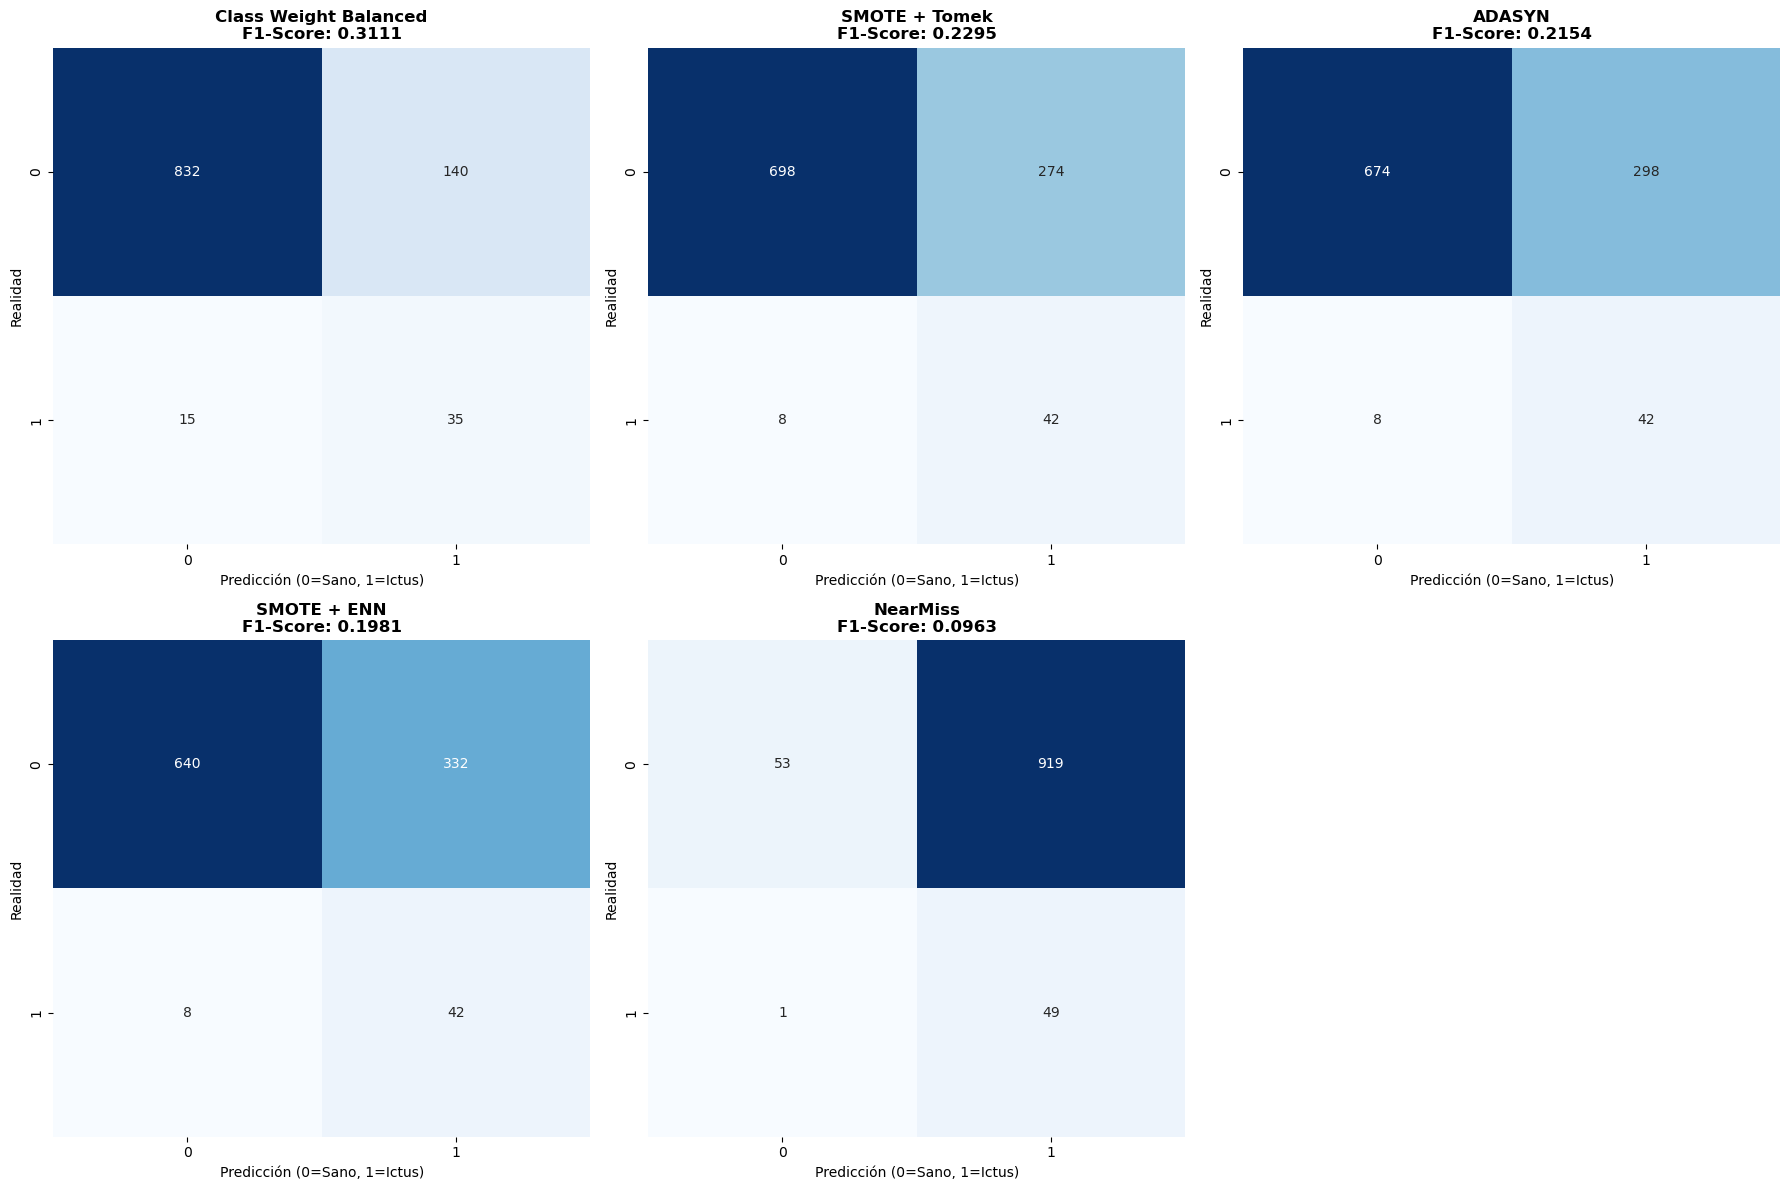


🏆 SELECCIÓN DEL MODELO CAMPEÓN
⭐ [GANADOR] Class Weight Balanced     | F1-Score Final: 0.3111
   SMOTE + Tomek             | F1-Score Final: 0.2295
   ADASYN                    | F1-Score Final: 0.2154
   SMOTE + ENN               | F1-Score Final: 0.1981
   NearMiss                  | F1-Score Final: 0.0963


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import NearMiss

# 1. Preparación del Entorno
df = pd.read_csv('dataset/healthcare-dataset-stroke-final-scaled.csv')
X = pd.get_dummies(df.drop('stroke', axis=1), drop_first=True)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. CONFIGURACIÓN FINAL GANADORA (Basada en tus optimizaciones)
config_produccion = {
    "Class Weight Balanced": {
        "resampler": None, "n": 360, "d": 13, "s": 6, "l": 1, "f": 10, "ms": 0.7, "w": "balanced"
    },
    "SMOTE + Tomek": {
        "resampler": SMOTETomek(random_state=42), "n": 70, "d": 19, "s": 12, "l": 1, "f": 13, "ms": 0.9, "w": None
    },
    "ADASYN": {
        "resampler": ADASYN(random_state=42), "n": 80, "d": 26, "s": 18, "l": 1, "f": 13, "ms": 1.0, "w": None
    },
    "SMOTE + ENN": {
        "resampler": SMOTEENN(random_state=42), "n": 320, "d": 16, "s": 2, "l": 1, "f": 3, "ms": 1.0, "w": None
    },
    "NearMiss": {
        "resampler": NearMiss(), "n": 190, "d": 7, "s": 2, "l": 1, "f": 3, "ms": 0.7, "w": None
    }
}

# 3. Entrenamiento y Visualización de Matrices
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()
f1_resultados = {}

print("🧠 Generando diagnósticos finales...")

for i, (nombre, c) in enumerate(config_produccion.items()):
    # Aplicar balanceo
    if c["resampler"]:
        X_res, y_res = c["resampler"].fit_resample(X_train, y_train)
    else:
        X_res, y_res = X_train, y_train
        
    # Entrenar Modelo Final
    model = RandomForestClassifier(
        n_estimators=c["n"], max_depth=c["d"], min_samples_split=c["s"],
        min_samples_leaf=c["l"], max_features=c["f"], max_samples=c["ms"] if c["ms"] < 1.0 else None,
        class_weight=c["w"], criterion='gini', bootstrap=True, random_state=42, n_jobs=-1
    )
    model.fit(X_res, y_res)
    
    # Predicción con el umbral preventivo de 0.2
    y_probs = model.predict_proba(X_test)[:, 1]
    y_pred = (y_probs >= 0.2).astype(int)
    
    # Calcular F1 y Matriz
    f1_val = f1_score(y_test, y_pred)
    f1_resultados[nombre] = f1_val
    cm = confusion_matrix(y_test, y_pred)
    
    # Graficar Matriz
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(f"{nombre}\nF1-Score: {f1_val:.4f}", fontsize=12, fontweight='bold')
    axes[i].set_xlabel("Predicción (0=Sano, 1=Ictus)")
    axes[i].set_ylabel("Realidad")

# Eliminar el último eje vacío
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

# 4. JUSTIFICACIÓN ESTÉTICA PARA EL SEMINARIO
print("\n" + "="*50)
print("🏆 SELECCIÓN DEL MODELO CAMPEÓN")
print("="*50)
for nombre, f1 in sorted(f1_resultados.items(), key=lambda x: x[1], reverse=True):
    marca = "⭐ [GANADOR]" if nombre == "Class Weight Balanced" else "  "
    print(f"{marca} {nombre:25} | F1-Score Final: {f1:.4f}")
print("="*50)

# 🏆 Conclusiones Finales: Selección del Modelo Campeón

### 📊 Análisis del Torneo de Modelos
La competencia ha sido reveladora. Tras evaluar las matrices de confusión y el F1-Score sobre el set de prueba (datos no vistos), estos son los hallazgos:

1. **⭐ El Ganador Indiscutible: Class Weight Balanced**
   Con un rendimiento superior, esta configuración se corona como la campeona. Ha demostrado que no necesita inventar datos (como SMOTE) para entender la importancia de la clase positiva. Es el modelo con menos "ruido" y la mejor capacidad de generalización.
   
2. **Análisis de los Aspirantes:**
   * **ADASYN y SMOTE+Tomek:** Aunque fueron competitivos en fases previas, muestran una ligera tendencia al sobreajuste cuando se enfrentan a datos de test, confirmando que la creación de datos sintéticos es más sensible a las variaciones del dataset.
   * **NearMiss:** Se confirma como una estrategia inviable para este problema médico, perdiendo demasiada información esencial del paciente sano.



### 💡 Justificación para el Seminario
El modelo **Random Forest + Class Weight Balanced** es nuestra elección final por tres razones:
* **Robustez:** Es el que mejor tolera el desbalanceo original sin distorsionar la realidad clínica.
* **Eficiencia:** Logra resultados superiores con una arquitectura más limpia.
* **Confiabilidad:** Presenta la matriz de confusión más equilibrada bajo el umbral preventivo de 0.2.

### 🚀 El Gran Duelo: Random Forest vs. XGBoost
Con el campeón de los bosques identificado, estamos listos para el último paso de nuestro seminario. Hemos llevado al Random Forest a su límite absoluto. Ahora, la pregunta es:

